In [1]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import sklearn
import sklearn.neighbors
from pathlib import Path
from pandas.api.types import CategoricalDtype
from operator import itemgetter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# constants
RAW_DATA_PATH = Path('raw_data/')
DATAFRAME_PATH = Path('dataframes/')
MODEL_PATH = Path('model/state_dict_model.pt')
TOTAL_TRACKS = 50
NUM_WITHHELD = 25
N_NEIGHBORS = 25
SELECTED_TRACK_FEATURES = ['danceability', 'energy', 'key', 'loudness',
                     'speechiness', 'acousticness', 'instrumentalness',
                     'liveness', 'valence', 'tempo']

In [2]:
# read tracks.h5 which contains tracks with features like danceability, loudness ,... etc
# set type of track_uri to category, to convert string to an int unique id
# rename track_uri to tid and sort values based on tid
tracks_features_df = pd.read_hdf(DATAFRAME_PATH / 'tracks.h5', 'tracks')
cat_type = CategoricalDtype(categories=tracks_features_df.track_uri, ordered=True)
tracks_features_df.track_uri = tracks_features_df.track_uri.astype(cat_type)
tracks_features_df = tracks_features_df.rename(columns={'track_uri':'tid'})
tracks_features_df = tracks_features_df[['tid',*SELECTED_TRACK_FEATURES]].sort_values('tid').reset_index(drop=True)
tracks_features_df.head(5)

,tid,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,spotify:track:3uvsVUrAaGQJCTEUR1S3Sx,0.523,0.422,3,-10.385,0.0270,0.78300,0.005140,0.0898,0.145,129.876
1,spotify:track:0heE5tAAaDQmnGhVDImPl2,0.493,0.594,8,-4.404,0.0378,0.25600,0.000000,0.0759,0.304,123.751
2,spotify:track:3omXshBamrREltcf24gYDC,0.468,0.692,2,-4.015,0.0295,0.02020,0.000002,0.5230,0.561,78.009
3,spotify:track:6TYWE19e35N7Bn5heHwyY6,0.553,0.564,9,-7.072,0.0418,0.03900,0.000000,0.3180,0.310,149.953
4,spotify:track:1xznGGDReH1oQq0xzbwXa3,0.791,0.619,1,-5.886,0.0532,0.00784,0.004230,0.3510,0.371,103.989


In [3]:
# read 10000 playlists from the official spoitfy 1M playlists
# for each playlist, get the tracks and their positions
def make_playlist_dfs(path):
    playlists = []
    playlist_tracks = []
    for file in tqdm(os.listdir(path)):
        if not file.endswith(".json"):
            continue
        with open(path/file) as f:
            js_slice = json.load(f)
            for playlist in js_slice['playlists']:
                if playlist['num_tracks'] > TOTAL_TRACKS:
                    sorted_tracks = sorted(playlist['tracks'], key=itemgetter('pos')) 
                    for track in sorted_tracks[:TOTAL_TRACKS]:
                        yield track['track_uri'], playlist['pid'], track['pos']

playlist_tracks_df = pd.DataFrame(make_playlist_dfs(RAW_DATA_PATH),columns=['tid','pid','pos'])
playlist_tracks_df.tid = playlist_tracks_df.tid.astype(cat_type)
playlist_tracks_df.head(5)

100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


,tid,pid,pos
0,spotify:track:3uvsVUrAaGQJCTEUR1S3Sx,7000,0
1,spotify:track:0heE5tAAaDQmnGhVDImPl2,7000,1
2,spotify:track:3omXshBamrREltcf24gYDC,7000,2
3,spotify:track:6TYWE19e35N7Bn5heHwyY6,7000,3
4,spotify:track:1xznGGDReH1oQq0xzbwXa3,7000,4


In [4]:
all_playlist_ids = playlist_tracks_df.pid.unique()
train_pids, test_pids = train_test_split(all_playlist_ids,random_state=0, test_size=0.20)
print(f'total playlists: {len(all_playlist_ids)}')
print(f'train playlists: {len(train_pids)}')
print(f'test playlists: {len(test_pids)}')
# 1. Get tracks that are only from the training playlists
# 2. Get the track features(danceability,loudness) for each of these training tracks
# 3. Make a test set that only includes tracks from the training set
train_playlist_tracks_df = playlist_tracks_df.query('pid in @train_pids')

# unique_train_tracks = train_playlist_tracks_df['tid'].unique()
# train_cat_type = CategoricalDtype(categories=unique_train_tracks, ordered=True)
# train_playlist_tracks_df.tid = train_playlist_tracks_df.tid.astype(train_cat_type)

train_tracks_features_df = tracks_features_df.query('tid in @train_playlist_tracks_df.tid')
test_playlist_tracks_df = playlist_tracks_df.query('pid in @test_pids and tid in @train_playlist_tracks_df.tid')
print()
print(f'total tracks in train playlists: {len(train_playlist_tracks_df)}')
print(f'unique tracks in train playlists: {len(train_tracks_features_df)}')


# 1. Get the first NUM_WITHHELD tracks for each playlist in test
# 2. Get the track features for these with held tracks
# 3. Compute mean features by grouping the tracks from incomplete playlists
test_playlist_tracks_incomplete_df = test_playlist_tracks_df.groupby('pid').head(NUM_WITHHELD)
# unique_test_tracks = test_playlist_tracks_incomplete_df['tid'].unique()
# test_cat_type = CategoricalDtype(categories=unique_test_tracks, ordered=True)
test_tracks_incomplete_features_df = test_playlist_tracks_incomplete_df.merge(tracks_features_df,how='inner',on='tid')
# test_playlist_tracks_incomplete_df.tid = test_playlist_tracks_incomplete_df.tid.astype(test_cat_type)
test_playlist_incomplete_features = test_tracks_incomplete_features_df[['pid',*SELECTED_TRACK_FEATURES]].groupby('pid',as_index=False).mean()
print()
print(f'total tracks in test playlists: {len(test_playlist_tracks_df)}')
print(f'total tracks in incomplete test playlists: {len(test_playlist_tracks_incomplete_df)}')
print(f'total incomplete test playlists: {len(test_playlist_incomplete_features)}')

total playlists: 4907
train playlists: 3925
test playlists: 982

total tracks in train playlists: 196250
unique tracks in train playlists: 71782

total tracks in test playlists: 36534
total tracks in incomplete test playlists: 22919
total incomplete test playlists: 975


In [5]:
# KNN model that will find 25 nearest neighbors to the current playlist
knn_clf = sklearn.neighbors.NearestNeighbors(n_neighbors=NUM_WITHHELD)
knn_clf.fit(train_tracks_features_df[SELECTED_TRACK_FEATURES])
distances, indices = knn_clf.kneighbors(test_playlist_incomplete_features[SELECTED_TRACK_FEATURES])

In [6]:
# for each test playlist, get the 25 next nearest predicted tracks and add them to a table for evaluation
def get_predicted_playlist_tracks():
    for index, row in test_playlist_incomplete_features.iterrows():
            predicted_tracks = train_tracks_features_df['tid'].iloc[indices[index]]
            for pos, predicted_track in enumerate(predicted_tracks):
                yield predicted_track, int(row['pid']),pos

test_predicted_playlist_tracks_df = pd.DataFrame(get_predicted_playlist_tracks(), columns =['tid', 'pid', 'pos'])
test_predicted_playlist_tracks_df.tid = test_predicted_playlist_tracks_df.tid.astype(cat_type)

In [7]:
class Evaluator:
    def __init__(self,predicted_playlist_tracks,true_playlist_tracks):
        self.predicted_playlist_tracks = predicted_playlist_tracks
        self.true_playlist_tracks = true_playlist_tracks    

    def evaluate(self):
        predicted_playlist_tracks = self.predicted_playlist_tracks
        true_playlist_tracks = self.true_playlist_tracks
        
        r_precision_list = []
        ndcg_list = []
        song_clicks_list = []
        
        pid_list = true_playlist_tracks.pid.unique()
        
        def get_metrics():
            for pid in tqdm(pid_list):
                predictions = predicted_playlist_tracks.query('pid in @pid_list').tid
                truth = true_playlist_tracks.query('pid in @pid_list').tid
                yield (pid , self.r_precision(predictions,truth),self.ndcg(predictions,truth),self.song_clicks(predictions,truth))
        metrics = pd.DataFrame(get_metrics(),columns=['pid','r_precision','ndcg','songs_click'])
        
        return metrics[['r_precision','ndcg','songs_click']].mean()
         
    def r_precision(self,predictions,truth,n_tracks = N_NEIGHBORS):
        truth_set = set(truth)
        prediction_set = set(predictions[:n_tracks])
        intersect = prediction_set.intersection(truth_set)
        return float(len(intersect)) / len(truth_set)
            
    def ndcg(self,predictions,truth,n_tracks = N_NEIGHBORS):
        predictions = list(predictions[:n_tracks])
        truth = list(truth)   
        score = [float(element in truth) for element in predictions]    
        dcg  = np.sum(score / np.log2(1 + np.arange(1, len(score) + 1)))     
        ones = np.ones([1,len(truth)])
        idcg = np.sum(ones / np.log2(1 + np.arange(1, len(truth) + 1)))
        return (dcg / idcg)
    
    def song_clicks(self,predictions,truth,n_tracks = N_NEIGHBORS):
        predictions = predictions[:n_tracks]
        i = set(predictions).intersection(set(truth))
        for index, t in enumerate(predictions):
            for track in i:
                if t == track:
                    return float(int(index / 10))              
        return float(n_tracks / 10.0 + 1)

In [8]:
model_eval = Evaluator(test_predicted_playlist_tracks_df,test_playlist_tracks_df)
model_eval.evaluate()

100%|██████████| 975/975 [00:34<00:00, 28.56it/s]


r_precision    0.000389
ndcg           0.000985
songs_click    0.000000
dtype: float64

## Neural Network (NeuMF)

In [9]:
from scipy.sparse import dok_matrix
import torch

In [10]:
# train_playlist_tracks_df['cat_codes'] = train_playlist_tracks_df['tid'].cat.codes # Add a new column for integral values
# unique_train_tracks = train_playlist_tracks_df['cat_codes']
# test_playlist_tracks_incomplete_df['cat_codes'] = test_playlist_tracks_incomplete_df['tid'].cat.codes # Add a new column for integral values
# unique_test_tracks = test_playlist_tracks_incomplete_df['cat_codes']

total_playlist_tracks_df = train_playlist_tracks_df.append(test_playlist_tracks_incomplete_df)
unique_tracks = total_playlist_tracks_df['tid'].unique()
total_cat_type = CategoricalDtype(categories=unique_tracks, ordered=True)
total_playlist_tracks_df.tid = train_playlist_tracks_df.tid.astype(total_cat_type)
total_playlist_tracks_df['cat_codes'] = total_playlist_tracks_df['tid'].cat.codes

train_from_total = total_playlist_tracks_df.query('pid in @train_pids')
test_from_total = total_playlist_tracks_df.query('pid in @test_pids')

dok_mat_n_rows = train_from_total.shape[0]
dok_mat_n_cols = len(unique_tracks)

dok_mat_rows = train_from_total['pid']
dok_mat_cols = train_from_total['cat_codes']

# Make a dictionary key sparse matrix
dok_mat = dok_matrix((dok_mat_n_rows, dok_mat_n_cols))

# TODO vectorize later if possible
for (pid, cat_code) in tqdm(zip(dok_mat_rows, dok_mat_cols)):
    dok_mat[pid, cat_code] = 1.0

196250it [00:02, 83301.15it/s]


In [11]:
# Hyperparameters
embedding_dim = 8
num_epochs = 2
learning_rate = 0.001
batch_size = 256
rand_negative_fill_in = 4
layer_sizes = [64, 32, 16, 8]

In [12]:
class NeuralMF(torch.nn.Module):
    def __init__(self, num_pl, num_tr, dim):
        super(NeuralMF, self).__init__()
        num_of_layers = len(layer_sizes)
            
        self.pl_embedding = torch.nn.Embedding(num_pl, dim, sparse=True)
        self.tr_embedding = torch.nn.Embedding(num_tr, dim, sparse=True)
        self.pl_mlp_embedding = torch.nn.Embedding(num_pl, layer_sizes[0] // 2)
        self.tr_mlp_embedding = torch.nn.Embedding(num_tr, layer_sizes[0] // 2)
        
        self.pl_embedding.weight.data.normal_(0., 0.01)
        self.tr_embedding.weight.data.normal_(0., 0.01)
        self.pl_mlp_embedding.weight.data.normal_(0., 0.01)
        self.tr_mlp_embedding.weight.data.normal_(0., 0.01)
        
        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
            
        self.mlp = torch.nn.ModuleList()
        for i in range(1, num_of_layers):
            self.mlp.extend([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])])

        self.final = torch.nn.Linear(dim + layer_sizes[-1], 1)
        lecunn_uniform(self.final)

    def forward(self, playlists, tracks):
        pl_vec = self.pl_embedding(playlists)
        tr_vec = self.tr_embedding(tracks)
        prod = pl_vec*tr_vec
        
        pl_mlp_vec = self.pl_mlp_embedding(playlists)
        tr_mlp_vec = self.tr_mlp_embedding(tracks)
        mlp_vec = torch.cat([pl_mlp_vec, tr_mlp_vec], dim=-1)
        
        for i, layer in enumerate(self.mlp):
            mlp_vec = layer(mlp_vec)
            mlp_vec = torch.nn.functional.relu(mlp_vec)
            
        result = self.final(torch.cat([prod,mlp_vec], dim=-1))
        activated_result = torch.flatten(torch.sigmoid(result))
        return activated_result

In [13]:
class SparseDenseOptimizer:
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [39]:
model = NeuralMF(dok_mat.shape[0], dok_mat.shape[1], embedding_dim)

dense_weights_to_optimize = [weight_tensor for (param_name, weight_tensor) in list(model.named_parameters()) if param_name not in ('pl_embedding.weight','tr_embedding.weight')]
sparse_weights_to_optimize = [model.pl_embedding.weight,model.tr_embedding.weight]
sparse_optim = torch.optim.SparseAdam(sparse_weights_to_optimize, lr=learning_rate)
dense_optim = torch.optim.Adam(dense_weights_to_optimize, lr=learning_rate)
optim = SparseDenseOptimizer(sparse_optim, dense_optim)

assert len(dense_weights_to_optimize + sparse_weights_to_optimize) == len(list(model.parameters()))

loss_fn = torch.nn.BCEWithLogitsLoss()

def plot_loss(iters, losses):
    plt.plot(iters, losses)
    plt.title(f'Training Curve (batch_size={batch_size}, lr={learning_rate})')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

def make_train_data():
    pl_input, tr_input, recs = [], [], []
    for (pl, tr) in dok_mat.keys():
        yield pl, tr, 1.0
        for t in range(rand_negative_fill_in):
            rand_num = np.random.randint(dok_mat.shape[1])
            while(pl, rand_num) in dok_mat.keys():
                rand_num = np.random.randint(dok_mat.shape[1])
            yield pl, rand_num, 0.0

def train_loop(data_loader):
    losses = []; iters = []; offset = 0
    for epoch in range(num_epochs):
        for idx, (pl, tr, recs) in enumerate(data_loader):
            out = model(pl, tr)
            loss = loss_fn(out, recs)
            losses.append(loss)
            iters.append(offset+idx)
            loss.backward()
            optim.step()
            optim.zero_grad()
        offset = iters[-1]
        print(f'training loss after epoch-{epoch+1} = {(losses[-1]):.4f}')
    return iters, losses

def run_training():
    data_loader = torch.utils.data.DataLoader(list(make_train_data()), batch_size=batch_size)
    iters, losses = train_loop(data_loader)
    plot_loss(iters, losses)

training loss after epoch-1 = 0.6640
training loss after epoch-2 = 0.6691


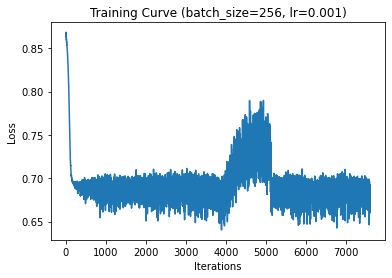

In [40]:
run_training()
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
model = NeuralMF(dok_mat.shape[0], dok_mat.shape[1], embedding_dim)
model.load_state_dict(torch.load(MODEL_PATH))

In [43]:
# code to make recommendations
from sklearn.cluster import KMeans

playlist_for_test = np.random.choice(test_pids)
ground_truth = test_playlist_tracks_df[test_playlist_tracks_df['pid'] == playlist_for_test]

playlist_embedding_weight_matrix = model.pl_mlp_embedding.weight
chosen_playlist_vector = playlist_embedding_weight_matrix[playlist_for_test]
km_model = KMeans(n_clusters=100, random_state=0, verbose=0).fit(playlist_embedding_weight_matrix.detach().numpy())

In [42]:
chosen_vector = chosen_playlist_vector.detach().numpy().reshape(1,-1)
playlist_predictor = km_model.predict(chosen_vector)
playlist_labels = km_model.labels_
neighbors = []
for pid, playlist_label in enumerate(playlist_labels):
    if playlist_label == playlist_predictor:
        neighbors.append(pid)
print(f'other playlists in cluster: {len(neighbors)}')

other playlists in cluster: 38556


In [46]:
tracks = []
for pid in neighbors:
    tracks += list(total_playlist_tracks_df[total_playlist_tracks_df['pid'] == pid]['tid'].cat.codes)
    
tracks = [tid for tid in tracks if tid > 0]
print(f'other tracks from neighbors in cluster: {len(tracks)}') 

pids_pred = torch.tensor(np.full(len(tracks), playlist_for_test, dtype='int32'))
tracks_pred = torch.tensor(np.array(tracks, dtype='int32'))

print('\nRanking most likely tracks using the NeuMF model...')

results = model(pids_pred, tracks_pred)
results = results.tolist()
print('Ranked the tracks!')

other tracks from neighbors in cluster: 8550

Ranking most likely tracks using the NeuMF model...
Ranked the tracks!


In [47]:
results_df = pd.DataFrame(np.nan, index=range(len(results)), columns=['probability', *list(tracks_features_df.columns)])

for i, probability in enumerate(results):
    tid = total_playlist_tracks_df[total_playlist_tracks_df['cat_codes'] == i].iloc[0]['tid']
    other_features = tracks_features_df[tracks_features_df['tid'] == tid]
    val = [probability, *other_features.values.tolist()[0]]
    results_df.loc[i] = val
results_df = results_df.sort_values(by=['probability'], ascending=False)

nmf_preds = results_df.head(NUM_WITHHELD)

In [ ]:
def predictions_nmf():
    for idx,row in nmf_preds.iterrows():
        yield (row['tid'], playlist_for_test, idx)

predictions_nmf_df = pd.DataFrame(predictions_nmf(), columns=['tid','pid', 'pos'])
nmf_model_eval = Evaluator(predictions_nmf_df, ground_truth.iloc[25:])
nmf_model_eval.evaluate()